In [524]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [488]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

x_train = df_train[['mean_return', 'volatility']].values
y_train = df_train['label'].values

x_test = df_test[['mean_return', 'volatility']].values
y_test = df_test['label'].values

### Helper Functions

In [499]:
def buy_and_hold(df):
    """
    This function calculates the buy and hold strategy.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing the data.

    Returns
    -------
    profit : pandas.Series
        Series containing the buy and hold strategy profit.
    """
    df = pd.read_csv('../data/test.csv')
    
    ## Buy on the first day of 2020 and sell on the last dat of 2021
    start_money = 100

    ## Buy on the first day of 2020
    initial = 100 / df['mean_adj_close'].loc[df['Year'] == 2020].iloc[0]
    ## Sell on the last day of 2021
    cash = df['mean_adj_close'].loc[df['Year'] == 2021].iloc[-1] * initial

    profit = cash
    return profit

def my_trading_strategy(df, **kwargs):
    """
    This function calculates the trading strategy.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing the data.

    Returns
    -------
    profit : pandas.Series
        Series containing the trading strategy profit.
    """

    
    label = kwargs['labels']
    eval = kwargs['eval']

    df['labels'] = label
    
    initial: int('Stock') = 0
    cash: int('Starting Money') = 100
    profit: int = 0
    total_profit: int = 0
    sell: int = 0
    total_loss: int = 0
    success: int = 0
    fail: int = 0
    count: list = []

    if eval == 'test':
        for i in range(len(df)):
            """
            Start buying 
            """

            if(df['labels'].iloc[i] == 1 and initial == 0):
                initial = cash / df['mean_adj_close'].iloc[i]

            elif(df['labels'].iloc[i] != 1 and initial != 0):
                sell = initial * df['mean_adj_close'].iloc[i]
                if(sell > cash):
                    profit = sell - cash
                    success += 1
                    total_profit += profit
                else:
                    loss = cash - sell
                    fail += 1
                    total_loss += loss 
                cash = sell
                initial = 0

        print(f'Success: {success}')
        print(f'Fails: {fail}')

        return total_profit

    elif eval == 'train':
        for i in range(len(df)):
            """
            Start buying 
            """

            if(df['label'].iloc[i] == 1 and initial == 0):
                initial = cash / df['mean_adj_close'].iloc[i]

            elif(df['label'].iloc[i] != 1 and initial != 0):
                sell = initial * df['mean_adj_close'].iloc[i]
                if(sell > cash):
                    profit = sell - cash
                    success += 1
                    total_profit += profit
                else:
                    loss = cash - sell
                    fail += 1
                    total_loss += loss 
                cash = sell
                initial = 0

        print(f'Number of successfull trades: {success}')
        print(f'Number of failed trades: {fail}')

        return total_profit


In [500]:
print(f'Buy and hold profit = ${round(buy_and_hold(df_test))}')
print(f'My trading strategy profit = ${round(my_trading_strategy(df_test, labels="none", eval="train"))}')

Buy and hold profit = $2898
Number of successfull trades: 18
Number of failed trades: 8
My trading strategy profit = $6094


### Preparing data for training

In [505]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### KNN
----

Finding the best value of k for KNN Euclidean distance

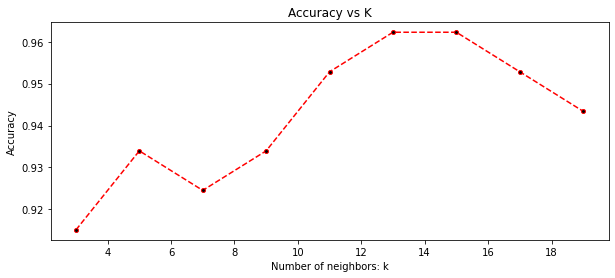

In [514]:
highest_accuracy: list = []
for k in range(3, 21, 2):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    highest_accuracy.append(accuracy_score(y_test, y_pred)) 

plt.figure(figsize=(10, 4))
plt.plot(range(3, 21, 2), highest_accuracy, color='red', linestyle='dashed', marker='o', markerfacecolor='black', markersize=4)
plt.title('Accuracy vs K')
plt.xlabel('Number of neighbors: k')
plt.ylabel('Accuracy')
plt.show()

Visually choosing k = 13

In [515]:
knn = KNeighborsClassifier(n_neighbors = 13, p=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 2)}')

Accuracy: 0.96


y_pred = learned labels for year 2020 and 2021

In [516]:
print(f'My trading strategy profit = ${round(my_trading_strategy(df_test, labels=y_pred, eval="test"))}')

Success: 18
Fails: 8
My trading strategy profit = $5652


### KNN Manhattan
----

Finding the best value of k for KNN Manhattan Distance

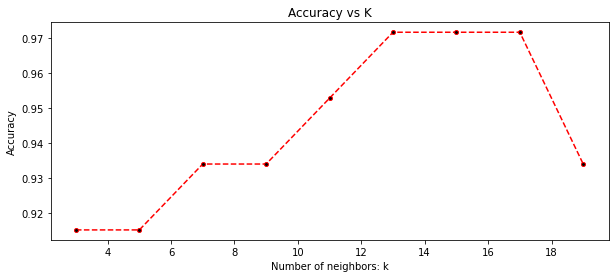

In [517]:
highest_accuracy: list = []
for k in range(3, 21, 2):
    knn = KNeighborsClassifier(n_neighbors = k, p = 1)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    highest_accuracy.append(accuracy_score(y_test, y_pred)) 

plt.figure(figsize=(10, 4))
plt.plot(range(3, 21, 2), highest_accuracy, color='red', linestyle='dashed', marker='o', markerfacecolor='black', markersize=4)
plt.title('Accuracy vs K')
plt.xlabel('Number of neighbors: k')
plt.ylabel('Accuracy')
plt.show()

In [518]:
knn = KNeighborsClassifier(n_neighbors = 13, p=1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 2)}')

Accuracy: 0.97


In [519]:
print(f'My trading strategy profit = ${round(my_trading_strategy(df_test, labels=y_pred, eval="test"))}')

Success: 18
Fails: 8
My trading strategy profit = $5803


#### KNN Minkowski
----
Finding the best value of k for Minkowski distance

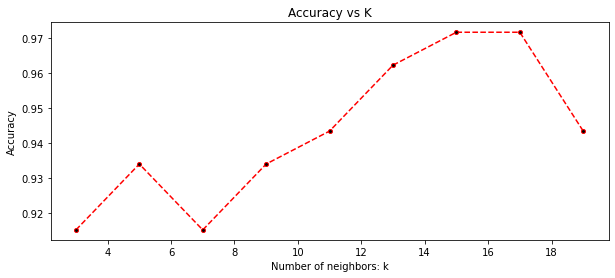

In [520]:
highest_accuracy: list = []

p = 1.5

def minkowski(a, b, p):
    return np.linalg.norm(a-b, ord=p)

for k in range(3, 21, 2):
    knn = KNeighborsClassifier(n_neighbors = k, metric= lambda a, b: minkowski(a, b, p))
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    highest_accuracy.append(accuracy_score(y_test, y_pred)) 

plt.figure(figsize=(10, 4))
plt.plot(range(3, 21, 2), highest_accuracy, color='red', linestyle='dashed', marker='o', markerfacecolor='black', markersize=4)
plt.title('Accuracy vs K')
plt.xlabel('Number of neighbors: k')
plt.ylabel('Accuracy')
plt.show()

In [521]:
knn = KNeighborsClassifier(n_neighbors = 13, metric= lambda a, b: minkowski(a, b, p))
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 2)}')

Accuracy: 0.96


In [522]:
print(f'My trading strategy profit = ${round(my_trading_strategy(df_test, labels=y_pred, eval="test"))}')

Success: 18
Fails: 8
My trading strategy profit = $5652
